In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# ✅ Install dependencies (once per session)
!pip install mne --quiet
!pip install torch --quiet
#!pip install pysdkit --quiet


# ✅ Mount Google Drive (optional)
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MesDossiers/Master CNN/MFA/mfa-internship/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.8 MB/s eta 0:00:00
Mounted at /content/drive
/content/drive/MyDrive/MesDossiers/Master CNN/MFA/mfa-internship


In [ ]:
%cd /content/drive/MyDrive/MesDossiers/Master CNN/MFA/mfa-internship/

/content/drive/MyDrive/MesDossiers/Master CNN/MFA/mfa-internship


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter
from scipy.signal import iirnotch, filtfilt, welch
import mne
import torch


In [ ]:
# Helpers Functions


def plot_mode_corr_matrix(
    corr_matrix,
    title="Average Correlation Between Modes (All Channels)",
    cmap="coolwarm",
    annot=True,
    figsize=(7, 6)
):
    """
    Plot a Seaborn heatmap of the mode correlation matrix.

    Parameters:
    - corr_matrix: square matrix of shape (n_modes, n_modes)
    - title: plot title
    - cmap: colormap (default: 'coolwarm')
    - annot: whether to show values in cells
    - figsize: figure size
    """
    n_modes = corr_matrix.shape[0]
    mode_labels = [f"Mode {i+1}" for i in range(n_modes)]

    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        corr_matrix,
        vmin=0, vmax=1,  # Use (0,1) since your compute_mode_corr_matrix always returns positive correlations
        cmap=cmap,
        annot=annot,
        fmt=".2f",
        xticklabels=mode_labels,
        yticklabels=mode_labels,
        square=True,
        cbar_kws={'label': 'Correlation'}
    )
    ax.set_title(title)
    ax.set_xlabel("Mode")
    ax.set_ylabel("Mode")
    plt.tight_layout()
    plt.show()

def double_notch(signal, fs):
    """Apply notch filters at 50 Hz and 100 Hz."""
    # First notch at 50 Hz
    b1, a1 = iirnotch(w0=50, Q=30, fs=fs)
    signal = filtfilt(b1, a1, signal)

    # Second notch at 100 Hz
    b2, a2 = iirnotch(w0=100, Q=30, fs=fs)
    signal = filtfilt(b2, a2, signal)

    return signal

def plot_mean_mode_psds_db(
    modes,                  # shape: (n_modes, n_samples, n_channels)
    sfreq,                  # sampling frequency
    omega=None,             # optional: array of mode peak frequencies
    nperseg=1024,           # window length for PSD
    standardize=False,      # z-score standardization flag
    notch=True,             # apply double notch filter
    eps=1e-12               # stability constant
):
    """
    Plot mean PSD (in dB) with std fill for each mode across all channels.

    Parameters:
    - modes: ndarray of shape (n_modes, n_samples, n_channels)
    - sfreq: sampling frequency (Hz)
    - omega: optional array of peak frequencies per mode
    - nperseg: segment length for Welch PSD
    - standardize: whether to z-score each signal
    - notch: whether to apply double_notch filtering
    - eps: small constant to avoid log(0) or division by 0
    """
    n_modes, _, n_channels = modes.shape

    fig, axes = plt.subplots(1, n_modes, figsize=(5 * n_modes, 4), sharey=True)

    if n_modes == 1:
        axes = [axes]  # Ensure iterable

    for i in range(n_modes):
        ax = axes[i]
        all_psd = []

        for ch in range(n_channels):
            signal = modes[i, :, ch]

            # === Preprocessing ===
            if notch:
                signal = double_notch(signal, sfreq)
            if standardize:
                signal = (signal - np.mean(signal)) / (np.std(signal) + eps)

            # === Compute PSD ===
            freqs, psd = welch(signal, fs=sfreq, nperseg=nperseg)

            # Remove line noise bands
            mask = ~((freqs > 45) & (freqs < 55)) & ~((freqs > 95) & (freqs < 105))
            psd_masked = psd[mask]
            all_psd.append(psd_masked)

        all_psd = np.array(all_psd) + eps  # Avoid log(0)
        mean_psd = np.mean(all_psd, axis=0)
        std_psd = np.std(all_psd, axis=0)
        freqs_masked = freqs[mask]

        # === Convert to dB ===
        mean_db = 10 * np.log10(mean_psd)
        std_db = 10 * np.log10(mean_psd + std_psd) - mean_db

        # === Plot ===
        ax.plot(freqs_masked, mean_db, color="black", label="Mean PSD")
        ax.fill_between(freqs_masked, mean_db - std_db, mean_db + std_db, color="gray", alpha=0.3)

        # === Title ===
        if omega is not None:
            peak_freq = omega[0, i].real
            ax.set_title(f"Mode {i} — Peak @ {peak_freq:.1f} Hz")
        else:
            ax.set_title(f"Mode {i}")

        ax.set_xlabel("Frequency (Hz)")
        ax.set_xscale("log")
        ax.grid(True, which='both', ls='--', alpha=0.5)
        if i == 0:
            ax.set_ylabel("Power (dB)")

    plt.suptitle("MVMD Modes — Mean PSD per Mode", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_mvmd_grid(
    original,
    modes,
    omega,
    fs,
    selected_channels,
    max_points=1000,
    duration=None,
    standardize_time=True,
    standardize_psd=False,
    notch=True,
    eps=1e-10,
    log_psd=True,
    log_freq=True
):
    """
    Plot:
    - Original signal per channel (row 0)
    - MVMD mode per channel (rows 1..n_modes)
    - Mean PSD per mode (last column)

    Parameters:
    - standardize_time: whether to z-score signals in time plots
    - standardize_psd: whether to z-score before PSD computation
    - notch: apply double notch filtering before PSD
    - eps: small value to prevent division by zero or log(0)
    """
    n_modes, n_samples, n_channels = modes.shape

    if duration:
        n_samples = min(n_samples, int(duration * fs))
        original = original[:, :n_samples]
        modes = modes[:, :n_samples, :]

    step = max(1, int(n_samples / max_points)) if max_points else 1
    t = np.arange(0, n_samples, step) / fs

    ncols = len(selected_channels) + 1
    nrows = n_modes + 1

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 2.2 * nrows), sharex=False)
    if ncols == 2:
        axes = axes.T
    axes = np.array(axes).reshape(nrows, ncols)

    # === Original signal ===
    for j, ch in enumerate(selected_channels):
        x = original[ch]
        x_ds = x[::step]
        axes[0, j].plot(t, x_ds, color='black')
        axes[0, j].set_title(f"Original — Ch {ch}")
        axes[0, j].set_xlabel("Time (s)")
        axes[0, j].set_ylabel("Amplitude")
        axes[0, j].grid(True)
    axes[0, -1].axis('off')

    # === Modes and PSD ===
    for i in range(n_modes):
        all_psd = []

        for j, ch in enumerate(selected_channels):
            y = modes[i, :n_samples, ch]
            y_ds = y[::step]

            # === Standardize for time plot ===
            if standardize_time:
                y_ds = (y_ds - np.mean(y_ds)) / (np.std(y_ds) + eps)

            axes[i+1, j].plot(t, y_ds)
            axes[i+1, j].set_title(f"Mode {i+1} — Ch {ch}")
            axes[i+1, j].set_xlabel("Time (s)")
            axes[i+1, j].set_ylabel("Amplitude")
            axes[i+1, j].grid(True)

            # === PSD preprocessing ===
            y_psd = y.copy()
            if notch:
                y_psd = double_notch(y_psd, fs)
            if standardize_psd:
                y_psd = (y_psd - np.mean(y_psd)) / (np.std(y_psd) + eps)

            f, psd = welch(y_psd, fs=fs, nperseg=fs*2)
            mask = ~((f > 45) & (f < 55)) & ~((f > 95) & (f < 105))
            all_psd.append(psd[mask])

        all_psd = np.array(all_psd) + eps  # prevent log(0)
        mean_psd = np.mean(all_psd, axis=0)
        std_psd = np.std(all_psd, axis=0)
        f_masked = f[mask]

        if log_psd:
            mean_val = 10 * np.log10(mean_psd)
            std_val = 10 * np.log10(mean_psd + std_psd) - mean_val
            ylabel = "Power (dB)"
        else:
            mean_val = mean_psd
            std_val = std_psd
            ylabel = "Power"

        ax = axes[i+1, -1]
        ax.plot(f_masked, mean_val, color="black")
        ax.fill_between(f_masked, mean_val - std_val, mean_val + std_val, color="gray", alpha=0.3)
        ax.set_title(f"PSD — Mode {i+1}")
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel(ylabel)
        if log_freq:
            ax.set_xscale("log")
        ax.grid(True, which="both", ls="--", alpha=0.5)

    plt.suptitle("MVMD Decomposition per Channel + Mean PSD", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def compute_mode_corr_matrix(modes):
    n_channels, n_modes, n_samples = modes.shape
    flat_modes = modes.reshape(-1, n_modes, n_samples)  # (n_channels, n_modes, n_samples)

    # Concatenate modes across channels
    all_modes = [flat_modes[:, i, :].flatten() for i in range(n_modes)]
    corr_matrix = np.corrcoef(all_modes)
    return corr_matrix

def plot_mode_psds_db_multi_channel_modes_first(
    modes,
    sfreq,
    channel_indices=None,
    standardize_time=False,
    standardize_psd=False,
    notch=True,
    log_scale=False,
    eps=1e-12
):
    """
    Plot PSDs (in dB) for each mode across selected channels.

    modes shape: (n_modes, n_samples, n_channels)
    """
    n_modes, n_samples, n_channels = modes.shape

    if channel_indices is None:
        channel_indices = list(range(n_channels))

    plt.figure(figsize=(12, 6))
    colors = plt.cm.tab10.colors
    handles = []

    for mode_idx in range(n_modes):
        color = colors[mode_idx % len(colors)]
        psds_list = []

        for ch in channel_indices:
            signal = modes[mode_idx, :, ch]

            if standardize_time:
                signal = (signal - np.mean(signal)) / (np.std(signal) + eps)

            freqs, psd = welch(signal, fs=sfreq, nperseg=min(1024, n_samples))

            if notch:
                mask = ~((freqs > 45) & (freqs < 55)) & ~((freqs > 95) & (freqs < 105))
                freqs = freqs[mask]
                psd = psd[mask]

            psd_db = 10 * np.log10(psd + eps)
            psds_list.append(psd_db)

        psds_array_db = np.array(psds_list)

        if standardize_psd:
            psds_array_db = (psds_array_db - np.mean(psds_array_db, axis=0)) / (np.std(psds_array_db, axis=0) + eps)

        for psd_curve_db in psds_array_db:
            plt.plot(freqs, psd_curve_db, color=color, alpha=0.3)

        handles.append(plt.Line2D([], [], color=color, label=f"Mode {mode_idx + 1}"))

    ch_str = ", ".join(str(ch) for ch in channel_indices)
    plt.title(f"PSD (dB) per Mode across channels {ch_str}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (dB)")

    if log_scale:
        plt.xscale("log")
        ax = plt.gca()
        ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'$10^{{{int(np.log10(x))}}}$'))

    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.legend(handles=handles, title="Modes")
    plt.tight_layout()
    plt.show()

def plot_mode_psds_db_multi_channel_modes_first(
    modes,
    sfreq,
    channel_indices=None,
    standardize_time=False,
    standardize_psd=False,
    notch=True,
    log_scale=False,
    eps=1e-12
):
    """
    Plot PSDs (in dB) for each mode across selected channels.

    Each mode is displayed in its own horizontal subplot.

    Parameters:
    - modes: np.ndarray (n_modes, n_samples, n_channels)
    - sfreq: float, sampling frequency
    - channel_indices: list of channels to include (default: all)
    - standardize_time: z-score signal before PSD
    - standardize_psd: z-score PSD across channels
    - notch: mask 50/100Hz bands
    - log_scale: apply log scale to x-axis
    - eps: small number to avoid log(0)
    """
    n_modes, n_samples, n_channels = modes.shape

    if channel_indices is None:
        channel_indices = list(range(n_channels))

    fig, axes = plt.subplots(1, n_modes, figsize=(5 * n_modes, 4), sharey=True)
    if n_modes == 1:
        axes = [axes]

    colors = plt.cm.tab10.colors

    for mode_idx in range(n_modes):
        ax = axes[mode_idx]
        psds_list = []
        color = colors[mode_idx % len(colors)]

        for ch in channel_indices:
            signal = modes[mode_idx, :, ch]

            if standardize_time:
                signal = (signal - np.mean(signal)) / (np.std(signal) + eps)

            freqs, psd = welch(signal, fs=sfreq, nperseg=min(1024, n_samples))

            if notch:
                mask = ~((freqs > 45) & (freqs < 55)) & ~((freqs > 95) & (freqs < 105))
                freqs = freqs[mask]
                psd = psd[mask]

            psd_db = 10 * np.log10(psd + eps)
            psds_list.append(psd_db)

        psds_array_db = np.array(psds_list)

        if standardize_psd:
            psds_array_db = (psds_array_db - np.mean(psds_array_db, axis=0)) / (np.std(psds_array_db, axis=0) + eps)

        for i, psd_curve_db in enumerate(psds_array_db):
            ch_color = colors[i % len(colors)]
            ax.plot(freqs, psd_curve_db, color=ch_color, alpha=0.3, label=f"Ch {channel_indices[i]}")

        ax.set_title(f"Mode {mode_idx + 1}")
        ax.set_xlabel("Frequency (Hz)")
        ax.grid(True, which="both", ls="--", alpha=0.5)

        if log_scale:
            ax.set_xscale("log")
            ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
            ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'$10^{{{int(np.log10(x))}}}$'))

        if mode_idx == 0:
            ax.set_ylabel("Power (dB)")

    handles = [plt.Line2D([0], [0], color=colors[i % len(colors)], label=f"Ch {ch}")
               for i, ch in enumerate(channel_indices)]
    fig.legend(handles=handles, loc='upper center', ncol=len(channel_indices), title="Channels")
    ch_str = ", ".join(str(ch) for ch in channel_indices)
    fig.suptitle(f"PSD (dB) per Mode — Channels {ch_str}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


In [ ]:
# The Main MVMD Pytorch Function
def mvmd_torch(signal, alpha, tau, K, DC, init, tol, max_N):
    import torch

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    signal = signal.to(device)

    C, T = signal.shape
    fs = 1 / float(T)

    # Mirror extension
    f_mirror = torch.zeros(C, 2*T, device=device)
    f_mirror[:, 0:T//2] = torch.flip(signal[:, 0:T//2], dims=[-1])
    f_mirror[:, T//2:3*T//2] = signal
    f_mirror[:, 3*T//2:2*T] = torch.flip(signal[:, T//2:], dims=[-1])
    f = f_mirror

    T = float(f.shape[1])
    t = torch.linspace(1/float(T), 1, int(T), device=device)
    freqs = t - 0.5 - 1/T
    T = int(T)

    Alpha = alpha * torch.ones(K, dtype=torch.cfloat, device=device)
    f_hat = torch.fft.fftshift(torch.fft.fft(f), dim=1)
    f_hat_plus = f_hat.clone()
    f_hat_plus[:, 0:T//2] = 0

    # Initialize u_hat
    u_hat_prev = torch.zeros((T, K, C), dtype=torch.cfloat, device=device)
    u_hat_curr = torch.zeros((T, K, C), dtype=torch.cfloat, device=device)

    # Initialize omega
    omega_prev = torch.zeros(K, dtype=torch.cfloat, device=device)
    omega_curr = torch.zeros(K, dtype=torch.cfloat, device=device)

    if init == 1:
        for i in range(K):
            omega_prev[i] = (0.5 / K) * i
    elif init == 2:
        omega_prev = torch.sort(
            torch.exp(torch.log(fs)) +
            (torch.log(torch.tensor(0.5)) - torch.log(fs)) * torch.rand(K, device=device)
        )[0]
    else:
        omega_prev[:] = 0

    if DC:
        omega_prev[0] = 0

    # Dual variable (only current needed)
    lamda_hat = torch.zeros((T, C), dtype=torch.cfloat, device=device)

    uDiff = tol + 2.2204e-16
    n = 0
    sum_uk = torch.zeros((T, C), dtype=torch.cfloat, device=device)

    while uDiff > tol and n < max_N:
        sum_uk = u_hat_prev[:, K-1, :] + sum_uk - u_hat_prev[:, 0, :]

        # First mode update
        k = 0
        for c in range(C):
            u_hat_curr[:, k, c] = (f_hat_plus[c, :] - sum_uk[:, c] - lamda_hat[:, c]/2) \
                                  / (1 + Alpha[k] * (freqs - omega_prev[k])**2)

        if not DC:
            omega_curr[k] = torch.sum(
                freqs[T//2:T].unsqueeze(0) @ torch.square(torch.abs(u_hat_curr[T//2:T, k, :]))
            ) / torch.sum(torch.square(torch.abs(u_hat_curr[T//2:T, k, :])))

        # Remaining modes
        for k in range(1, K):
            sum_uk = u_hat_curr[:, k-1, :] + sum_uk - u_hat_prev[:, k, :]
            for c in range(C):
                u_hat_curr[:, k, c] = (f_hat_plus[c, :] - sum_uk[:, c] - lamda_hat[:, c]/2) \
                                      / (1 + Alpha[k] * (freqs - omega_prev[k])**2)

            omega_curr[k] = torch.sum(
                freqs[T//2:T].unsqueeze(0) @ torch.square(torch.abs(u_hat_curr[T//2:T, k, :]))
            ) / torch.sum(torch.square(torch.abs(u_hat_curr[T//2:T, k, :])))

        # Update lambda (dual ascent)
        # (tau is usually 0, so this has no effect unless tau > 0)
        lamda_hat = lamda_hat  # + tau * (torch.sum(u_hat_curr, dim=1) - f_hat_plus)

        # Convergence check
        uDiff = 2.2204e-16
        for i in range(K):
            delta = u_hat_curr[:, i, :] - u_hat_prev[:, i, :]
            uDiff += (delta * delta.conj()).real.sum() / T

        # Swap buffers
        u_hat_prev, u_hat_curr = u_hat_curr, u_hat_prev
        omega_prev, omega_curr = omega_curr, omega_prev

        n += 1

    # Final omega
    omega = omega_prev.unsqueeze(0)

    # Final reconstruction
    u_hat = torch.zeros((T, K, C), dtype=torch.cfloat, device=device)
    for c in range(C):
        u_hat[T//2:T, :, c] = u_hat_prev[T//2:T, :, c]
        idx = list(range(1, T//2+1))
        idx.reverse()
        u_hat[idx, :, c] = torch.conj(u_hat_prev[T//2:T, :, c])
        u_hat[0, :, c] = torch.conj(u_hat[-1, :, c])

    u = torch.zeros((K, T, C), dtype=torch.cfloat, device=device)
    for k in range(K):
        for c in range(C):
            u[k, :, c] = torch.fft.ifft(torch.fft.ifftshift(u_hat[:, k, c])).real

    # Remove mirror
    u = u[:, T//4:3*T//4, :]

    # Compute final u_hat
    T_reduced = u.shape[1]
    u_hat_final = torch.zeros((T_reduced, K, C), dtype=torch.cfloat, device=device)
    for k in range(K):
        for c in range(C):
            u_hat_final[:, k, c] = torch.fft.fftshift(torch.fft.fft(u[k, :, c])).conj()

    u = torch.fft.ifftshift(u, dim=-1)

    return u.real, u_hat_final, omega


In [ ]:
# ✅ Check CUDA (GPU available?)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

# ✅ Check Memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Using: cuda
Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === Load your multichannel MEG signal ===
# Load MEG .fif file
raw = mne.io.read_raw_fif("data/sub-01_ses-01_task-rest_proc-filt_raw.fif", preload=True)
raw = raw.copy().pick('meg')
data = raw.get_data()  # shape: (n_channels, n_times)
sfreq = raw.info["sfreq"]
print("sfreq",sfreq)
print("Shape:", data.shape)  # Should be (306, 82500) or similar


Using device: cuda
Opening raw data file data/sub-01_ses-01_task-rest_proc-filt_raw.fif...
    Range : 34500 ... 116999 =    138.000 ...   467.996 secs
Ready.
Reading 0 ... 82499  =      0.000 ...   329.996 secs...
sfreq 250.0
Shape: (306, 82500)


In [ ]:
n_channels, n_samples = data.shape
fs = 250

In [ ]:
# # === Convert to torch tensor and send to GPU ===
# signal = torch.tensor(data_notched, dtype=torch.float32, device=device)  # (n_channels, n_samples)
signal = torch.tensor(data, dtype=torch.float32, device=device)  # (n_channels, n_samples)

# === Standardize (z-score per channel) ===
mean = signal.mean(dim=1, keepdim=True)
std = signal.std(dim=1, keepdim=True) + 1e-8
signal_z = (signal - mean) / std  # shape: (n_channels, n_samples)


# === MVMD parameters ===
K = 5
alpha = 2000
tau = 0
DC = False
init = 1
tol = 1e-6
max_N = 500

# === Run MVMD ===
print("Running MVMD...")
u, u_hat, omega = mvmd_torch(
    signal_z,
    alpha=alpha,
    tau=tau,
    K=K,
    DC=DC,
    init=init,
    tol=tol,
    max_N=max_N
)  # u: (K, n_samples, n_channels)


# === Rescale modes back to original scale ===
u_rescaled = u.clone()
for ch in range(n_channels):
    u_rescaled[:, :, ch] = u[:, :, ch] * std[ch] + mean[ch]

# === Move to CPU and convert to numpy ===
u_np = u_rescaled.detach().cpu().numpy()
omega_np = omega[-1].detach().cpu().numpy() * fs  # Convert to Hz


# === Save to .npz ===
os.makedirs("outputs", exist_ok=True)
np.savez("outputs/mvmd_modes_sub-01.npz", u=u_np, omega=omega_np)
print("✅ Saved MVMD modes and omega (Hz) to outputs/mvmd_modes_sub-01.npz")
print("u shape:", u_np.shape)
print("omega shape:", omega_np.shape)

Running MVMD...


In [ ]:
# === Load saved modes ===
data_modes = np.load("mvmd_modes_sub-01.npz")
u = data_modes["u"]        # shape: (K, T, C)
omega = data_modes["omega"]  # shape: (K,)

In [ ]:
n_modes, T, C = u.shape
eps = 1e-10
nperseg = min(1024, T)

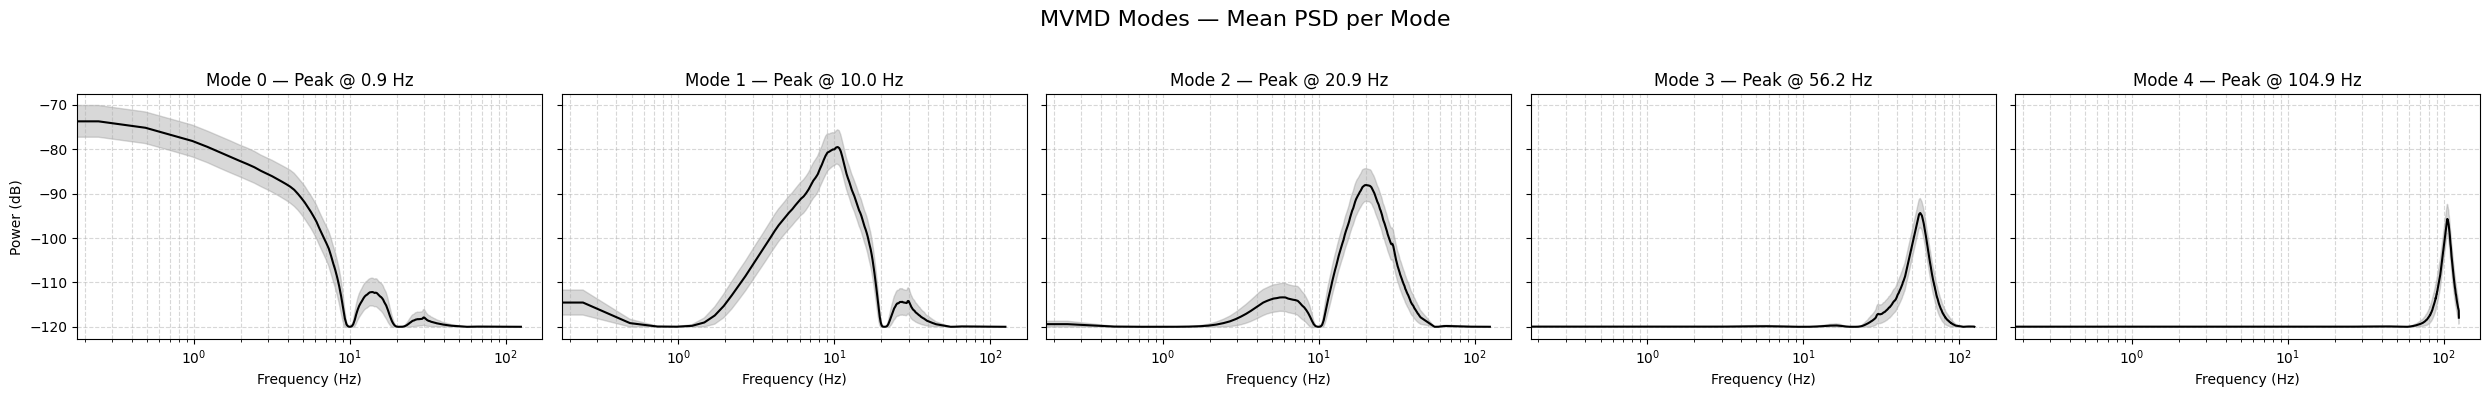

In [ ]:
plot_mean_mode_psds_db(
    modes=u,
    sfreq=fs,
    omega=omega,
    standardize=False,
    notch=True,
    eps=1e-12
)


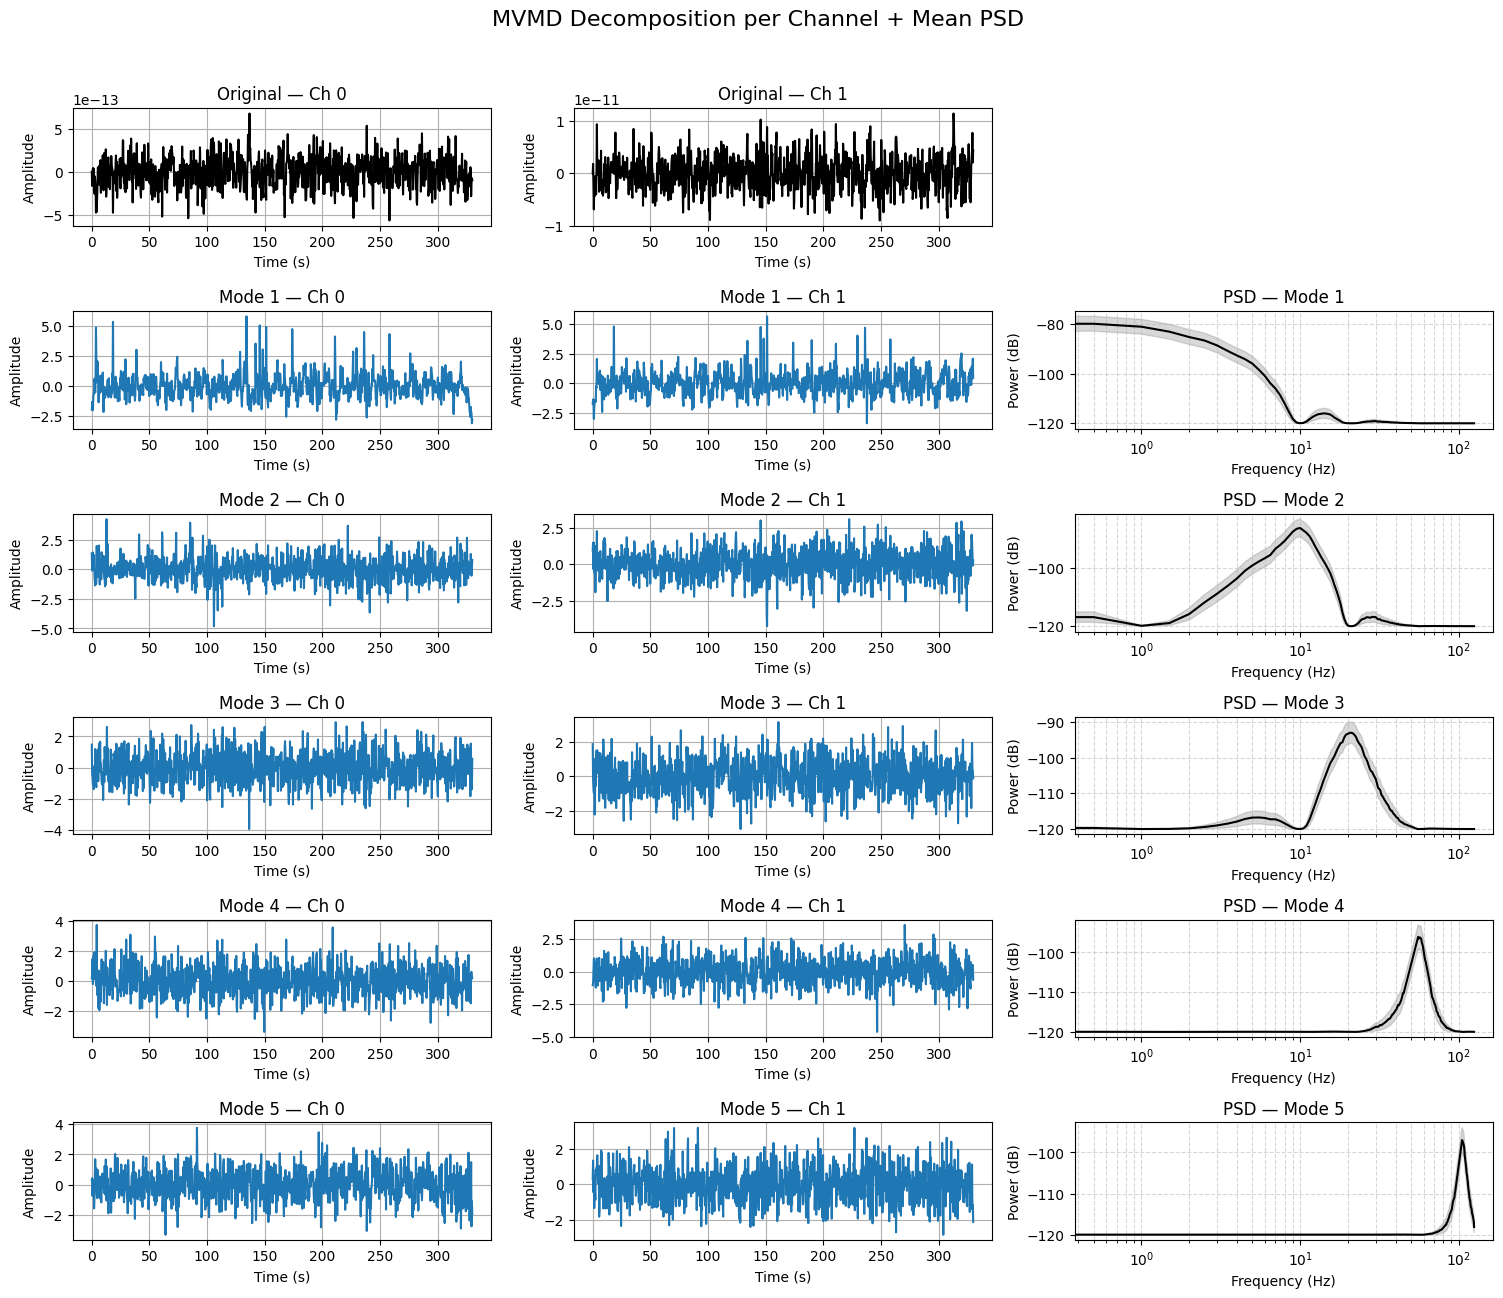

In [ ]:
# Load your .fif data
# # import mne
# raw = mne.io.read_raw_fif("data/sub-01_ses-01_task-rest_proc-filt_raw.fif", preload=True)
# raw = raw.pick('meg')  # MEG channels only
# data = raw.get_data()  # shape (n_channels, n_samples)
# #sfreq = raw.info["sfreq"]

# # # Load MVMD result
# npz = np.load("mvmd_modes_sub-01.npz")
# u = npz["u"]  # shape: (n_modes, n_samples, n_channels)
# omega = npz["omega"]  # shape: (1, n_modes)


# Select channels to display
selected_channels = [0, 2, 4]  # or any list of valid indices

plot_mvmd_grid(
    original=data,
    modes=u,
    omega=omega,
    fs=fs,
    selected_channels=[0, 1],
    standardize_time=True,
    standardize_psd=False,
    notch=True,
    eps=1e-12
)



In [ ]:
compute_mode_corr_matrix(u)
plot_mode_corr_matrix(corr_matrix)

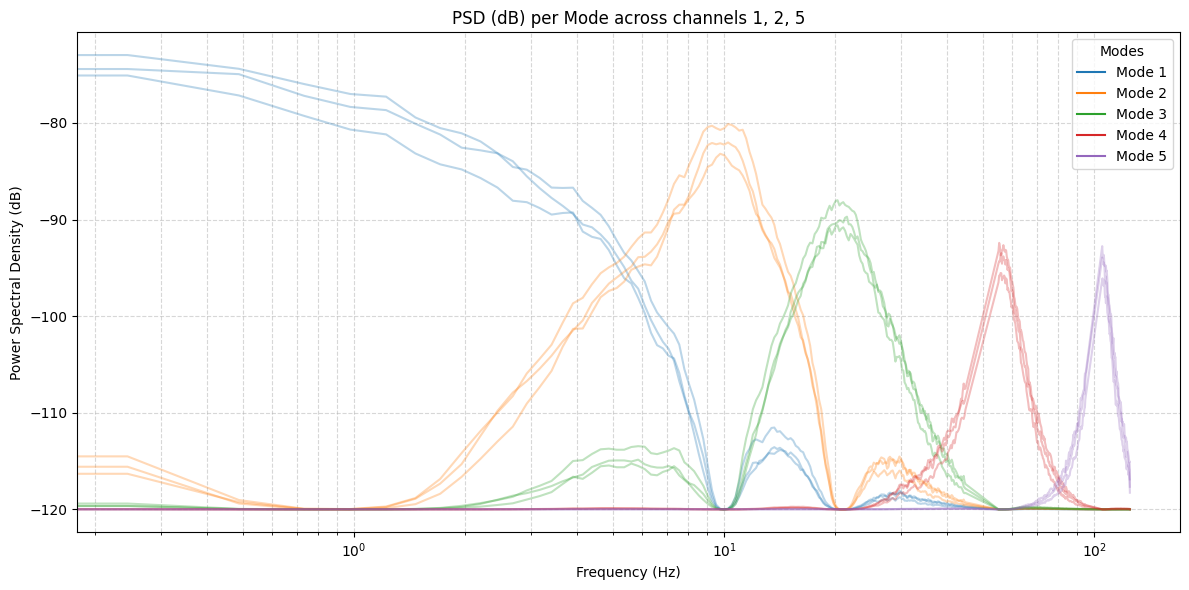

In [ ]:
plot_mode_psds_db_multi_channel_modes_first(
    u,                 # shape: (5, 82500, 306)
    sfreq=250,
    channel_indices=[1, 2, 5],
    standardize_time=False,
    standardize_psd=False,
    notch=True,
    log_scale=True
)


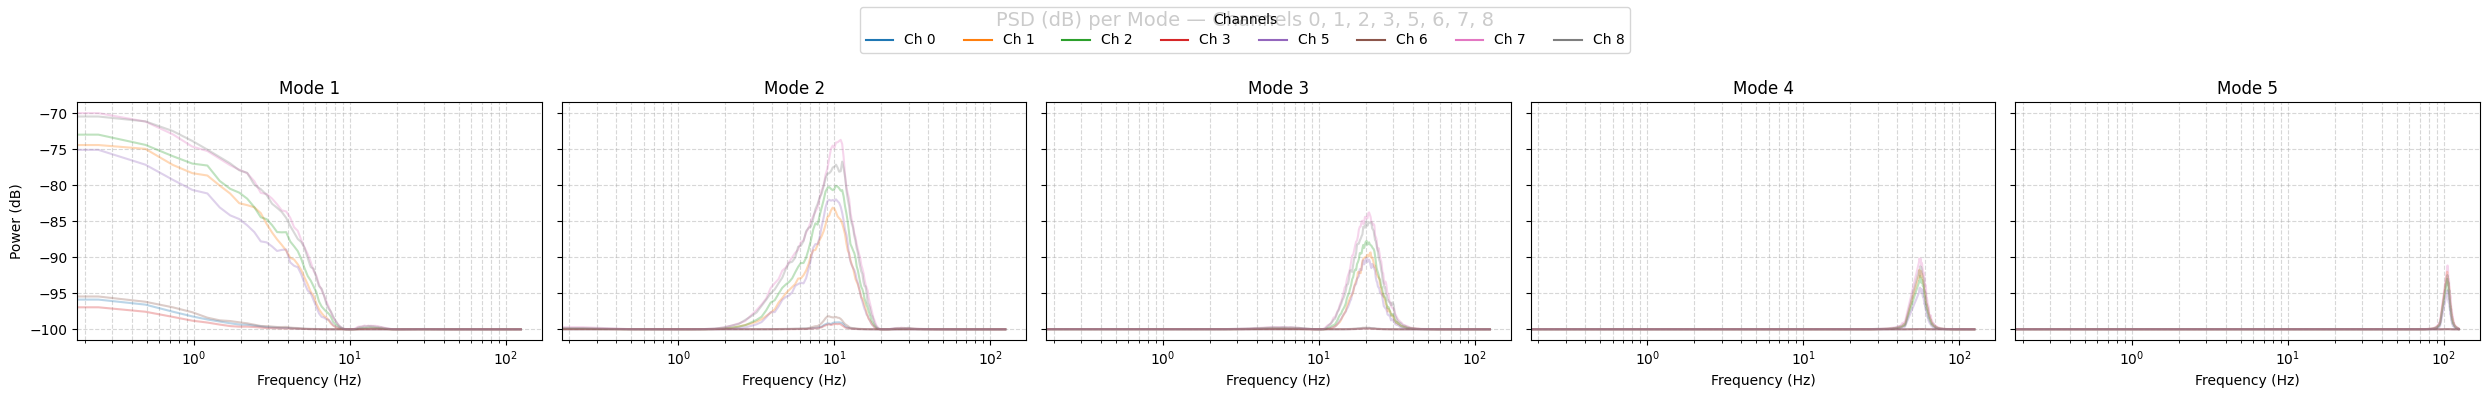

In [ ]:
plot_mode_psds_db_multi_channel_modes_first(
    modes=u,        # shape (n_modes, n_samples, n_channels)
    sfreq=250,               # for example: 1000 Hz
    channel_indices=[0, 1, 2,3,5,6,7,8],# select specific channels (by index)
    standardize_time=False,   # optional: z-score time signals
    standardize_psd=False,    # optional: z-score PSDs
    notch=True,               # apply 50/100Hz notch
    log_scale=True,
    eps = 1e-10               # linear frequency scale
)
